In [23]:
import sys
sys.path.append('/Users/paolamartire/shocks')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import k3match
from scipy.optimize import fsolve
import pickle 

from shock_zone import shock_direction
from Utilities.operators import make_tree, calc_grad

# %matplotlib widget # (to go back normal %matplotlib inline)
# mpl.rcParams['figure.dpi'] = 100

In [24]:
delta = 0.039 #0.05 as in shockzone
z_chosen = 0 
save = False

In [25]:
# def ray_tracer(sim_tree, X, Y, Z, x_zone, y_zone, z_zone, idx, div, dir, delta, direction):
#     point = np.array([x_zone[idx], y_zone[idx], z_zone[idx]])
#     div_v = div[idx]
#     dir_sh = np.array(dir[idx])

#     check_zone = 0 # to check if the new point is in the shock zone
#     while check_zone < delta:
#         # move along shock direction 
#         if direction == 'post':
#             new_point = point - dir_sh * delta
#         elif direction == 'pre':
#             new_point = point + dir_sh * delta
        
#         # find the nearest points in the grid and in the shock zone
#         _, i_tree  = sim_tree.query(new_point)
#         x_new = X[i_tree]
#         y_new = Y[i_tree]
#         z_new = Z[i_tree]
#         point = [x_new, y_new, z_new]

#         (idx_zone, dist) = k3match.nearest_cartesian(x_zone, y_zone, z_zone, x_new, y_new, z_new)
#         idx_zone = int(idx_zone)
#         check_zone = dist 
                    
#         div_next = div[idx_zone]
#         dir_next = dir[idx_zone]

#         # if lower div v, you discard the ray.
#         if div_next < div_v:
#             # print('pass')
#             return False # so then you don't take this cell

#         # if opposite direction in shocks, you turn/stop.
#         if np.dot(dir_sh, dir_next) < 0:
#             check_zone = 1e4 # so you exit from the while
 
#     final_tree_index = i_tree
    
#     return final_tree_index

In [26]:
def ray_tracer(sim_tree, X, Y, Z, are_u_shock, x_zone, y_zone, z_zone, idx, div, dir, delta, direction):
    point = np.array([x_zone[idx], y_zone[idx], z_zone[idx]])
    div_v = div[idx]
    dir_sh = np.array(dir[idx])

    if direction == 'post':
        delta = - delta

    check_zone = True # to check if the new point is in the shock zone
    while check_zone == True:
        new_point = point + dir_sh * delta
        # move along shock direction 
        
        # find the nearest points in the grid and in the shock zone
        _, i_tree  = sim_tree.query(new_point)
        check_zone = are_u_shock[i_tree]

        if check_zone == True:
            # dumb way 
            x_new = X[i_tree]
            y_new = Y[i_tree]
            z_new = Z[i_tree]
            point = [x_new, y_new, z_new]
            idx_zone, _ = k3match.nearest_cartesian(x_zone, y_zone, z_zone, x_new, y_new, z_new)
            idx_zone = int(idx_zone)
            div_next = div[idx_zone]
            dir_next = dir[idx_zone]

            # if lower div v, you discard the ray.
            if div_next < div_v:
                # print('pass')
                return False # so then you don't take this cell

            # if opposite direction in shocks, you turn/stop.
            if np.dot(dir_sh, dir_next) < 0:
                check_zone = False # so you exit from the while
 
    final_tree_index = i_tree
    
    return final_tree_index

def shock_surface(sim_tree, X, Y, Z, Temp, are_u_shock, x_zone, y_zone, z_zone, div, dir, delta):
    surface_mach = []
    surface_x = []
    surface_y = []
    surface_z = []
    post_x = []
    post_y = []
    post_z = []
    pre_x = []
    pre_y = []
    pre_z = []

    # loop over all the cells in the shock zone
    for idx in range(len(x_zone)):
        print(idx)
        post_tree_index = ray_tracer(sim_tree, X, Y, Z, are_u_shock, x_zone, y_zone, z_zone, idx, div, dir, delta, direction = 'post')
        if post_tree_index == False:
            continue
        else:
            Tpost = Temp[post_tree_index]
            pre_tree_index = ray_tracer(sim_tree, X, Y, Z, are_u_shock, x_zone, y_zone, z_zone, idx, div, dir, delta, direction = 'pre')
            if pre_tree_index == False:
                continue
            else:
                Tpre = Temp[pre_tree_index]

                bump = Tpost/Tpre
                # check if the bump is in the same direction of ds. CHECK THIS
                if bump < 1:
                    continue 

                surface_x.append(x_zone[idx])
                surface_y.append(y_zone[idx])
                surface_z.append(z_zone[idx])
                post_x.append(X[post_tree_index])
                post_y.append(Y[post_tree_index])
                post_z.append(Z[post_tree_index])
                pre_x.append(X[pre_tree_index])
                pre_y.append(Y[pre_tree_index])
                pre_z.append(Z[pre_tree_index])

                def temperature_bump(mach):
                    gamma = 5/3
                    to_solve =  ((gamma-1) * mach**2 + 2) * (2 * gamma * mach**2 - (gamma-1)) / ((gamma+1)**2 * mach**2) - bump
                    to_solve = float(to_solve)
                    return to_solve
                
                mach = fsolve(temperature_bump, 1.5)
                surface_mach.append(mach)
            
    surface_mach = np.array(surface_mach)
    surface_x = np.array(surface_x)
    surface_y = np.array(surface_y)
    surface_z = np.array(surface_z)
    post_x = np.array(post_x)
    post_y = np.array(post_y)
    post_z = np.array(post_z)
    pre_x = np.array(pre_x)
    pre_y = np.array(pre_y)
    pre_z = np.array(pre_z)

    return surface_mach, surface_x, surface_y, surface_z, post_x, post_y, post_z,  pre_x, pre_y, pre_z


In [27]:
# Import data
shockzone = np.loadtxt(f'shockzone.txt')
shockdir = np.loadtxt(f'shockdir.txt')

x_zone = np.array(shockzone[0])
y_zone = shockzone[1]
z_zone = shockzone[2]
div = shockzone[3]
Tzone = shockzone[4]

x_dir = shockdir[0]
y_dir = shockdir[1]
z_dir = shockdir[2]
dir = []
for i in range(len(x_dir)):
    dir.append([x_dir[i], y_dir[i], z_dir[i]])

In [28]:
sim_tree, X, Y, Z, VX, VY, VZ, Den, Press, Temp = make_tree()

all T=0, bro. CHANGE!


In [29]:
with open('shockbool.pkl', 'rb') as filebool:
    are_u_shock = pickle.load(filebool)

In [30]:
surface_mach, surface_x, surface_y, surface_z, post_x, post_y, post_z, pre_x, pre_y, pre_z = shock_surface(sim_tree, X, Y, Z, Temp, are_u_shock, x_zone, y_zone, z_zone, div, dir, delta)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146


/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_49224/16150474.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx_zone = int(idx_zone)
/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_49224/16150474.py:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  to_solve = float(to_solve)


147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396


In [31]:
if save == True:
    surface_mach_txt = np.concatenate(surface_mach)
    with open(f'shocksurface.txt', 'w') as file:
        file.write(f'# Coordinates of the points in the shock surface \n# X \n') 
        file.write(' '.join(map(str, surface_x)) + '\n')
        file.write('# Y \n') 
        file.write(' '.join(map(str, surface_y)) + '\n')
        file.write('# Z \n') 
        file.write(' '.join(map(str, surface_z)) + '\n')
        file.write('# mach number v \n') 
        file.write(' '.join(map(str, surface_mach_txt)) + '\n')
        file.close()

In [18]:
len(surface_mach)

4202

In [32]:
outlier = np.argmin(surface_mach[np.logical_and(surface_z<z_chosen+delta, surface_z>z_chosen-delta)])

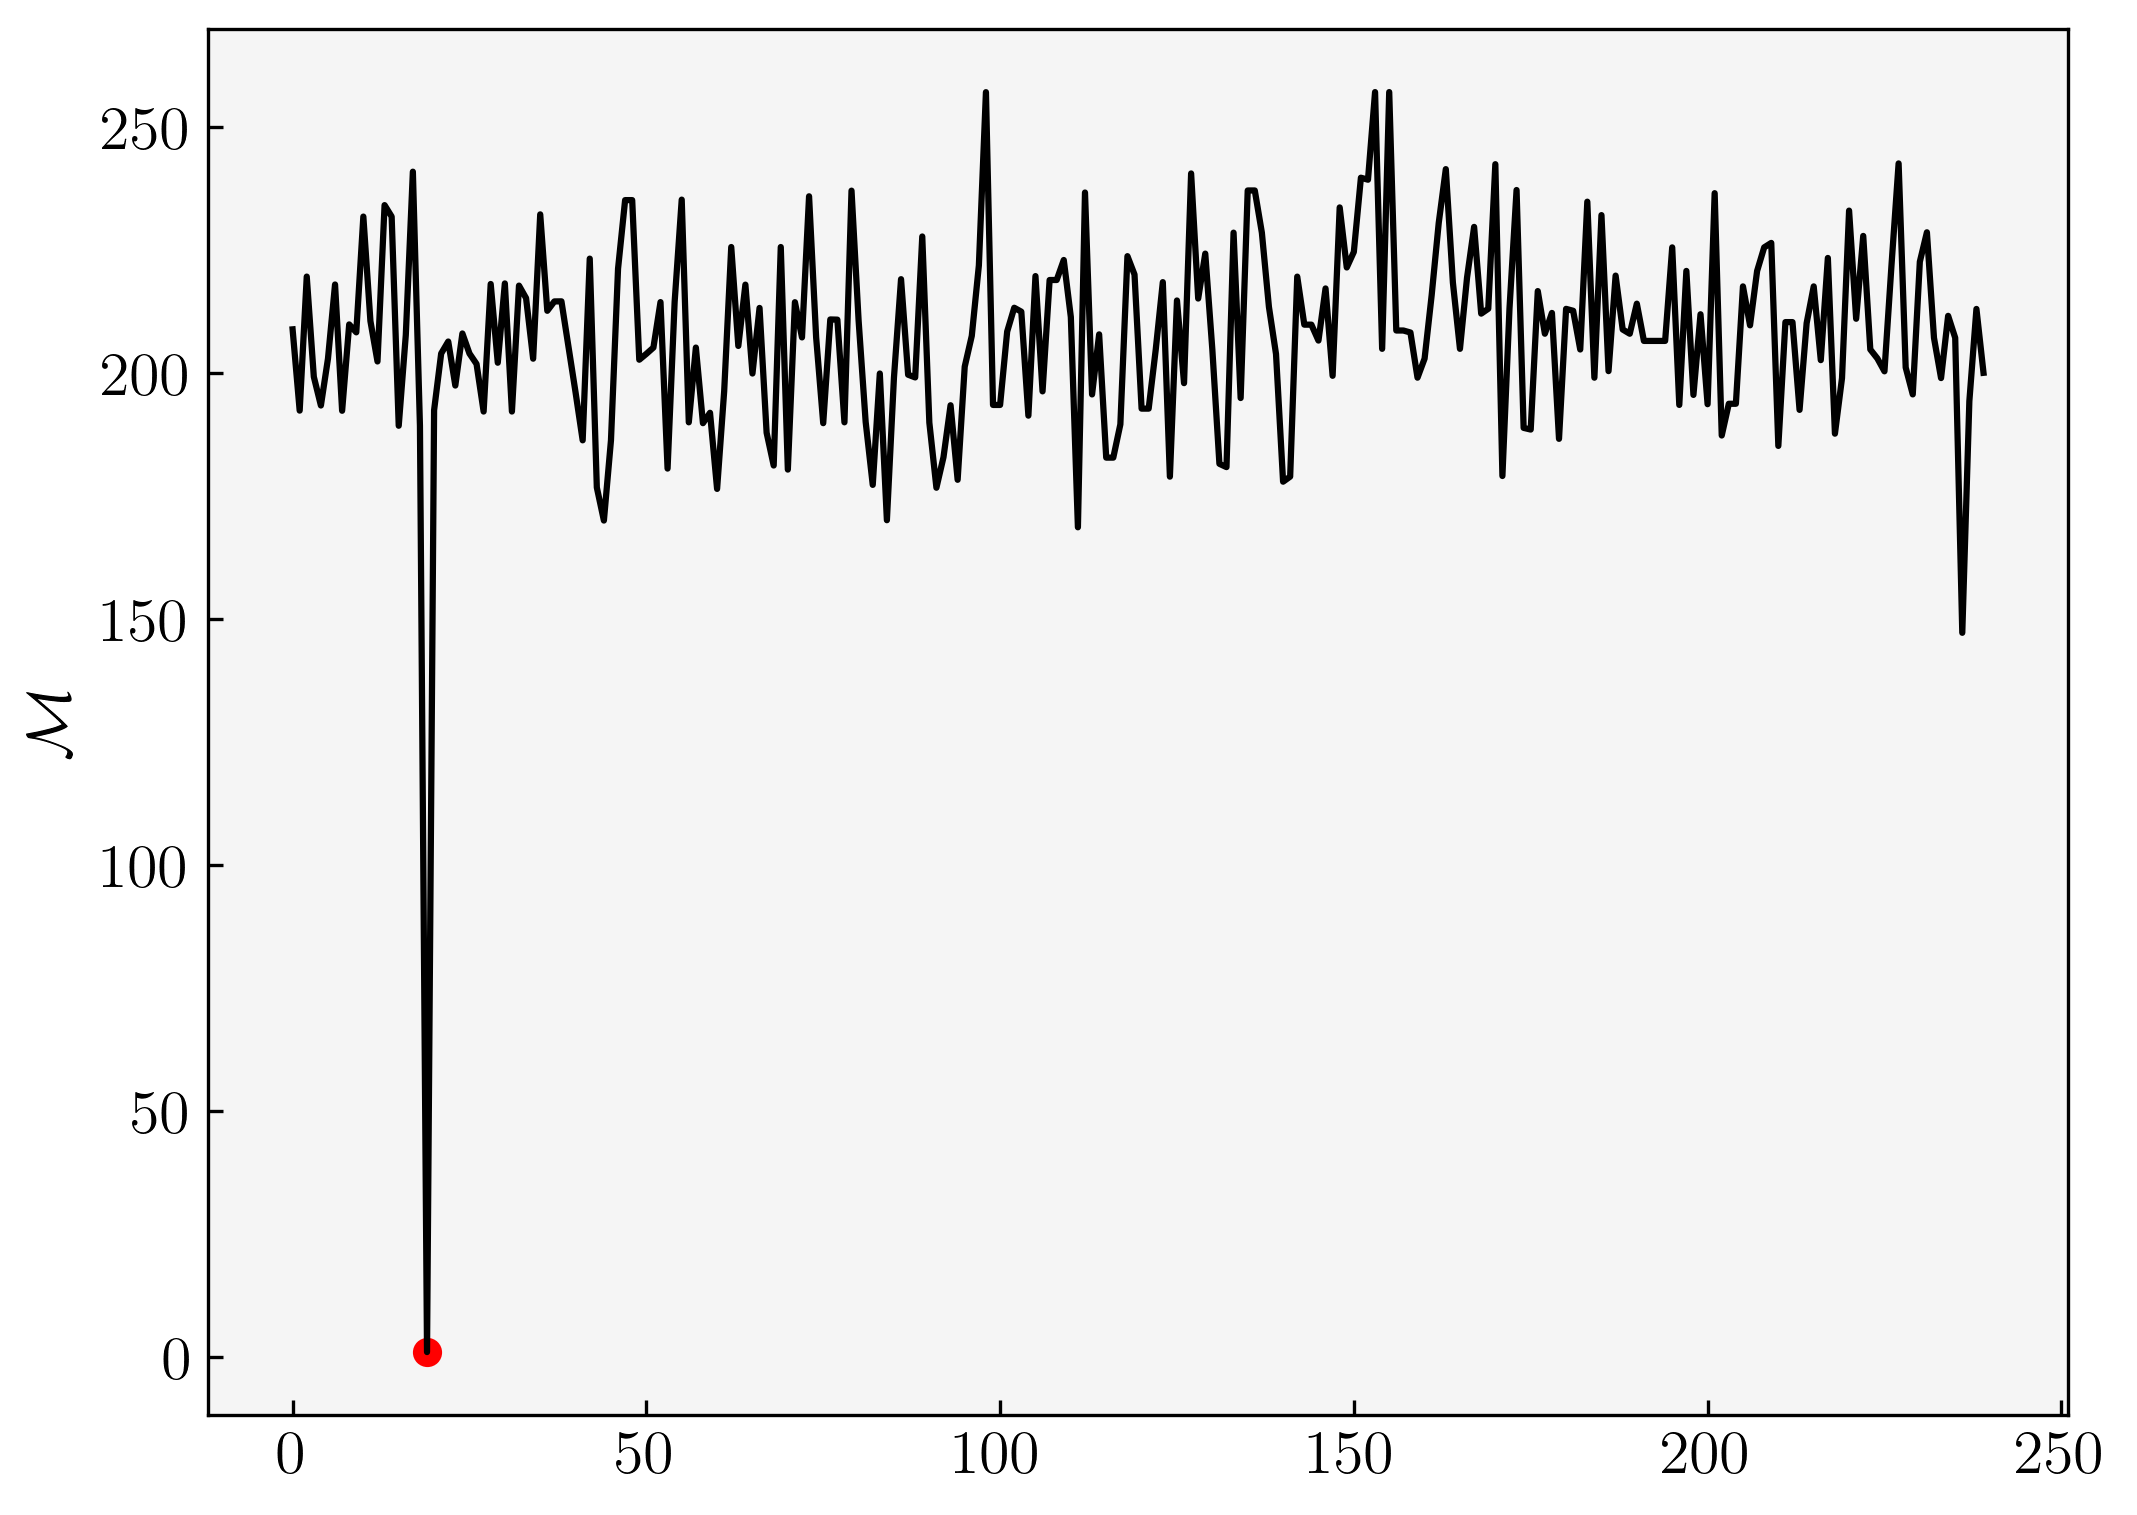

In [66]:
plt.plot(surface_mach[np.logical_and(surface_z<z_chosen+delta, surface_z>z_chosen-delta)], c = 'k')
plt.scatter(outlier, surface_mach[np.logical_and(surface_z<z_chosen+delta, surface_z>z_chosen-delta)][outlier], c = 'r')
plt.ylabel(r'$\mathcal{M}$', fontsize = 15)
plt.savefig(f'Figs/6mach_z{z_chosen}.png')
plt.show()

In [67]:
# Cross section
slice_zone = np.logical_and(z_zone<z_chosen+delta, z_zone>z_chosen-delta)
zone_cross_x = x_zone[slice_zone]
zone_cross_y = y_zone[slice_zone]

slice_surface = np.logical_and(surface_z<z_chosen+delta, surface_z>z_chosen-delta)
surface_cross_x = surface_x[slice_surface]
surface_cross_y = surface_y[slice_surface]

slice_post = np.logical_and(post_z<z_chosen+delta, post_z>z_chosen-delta)
zone_post_x = post_x[np.logical_and(slice_surface, slice_post)]
zone_post_y = post_y[np.logical_and(slice_surface, slice_post)]

slice_pre = np.logical_and(pre_z<z_chosen+delta, pre_z>z_chosen-delta)
zone_pre_x = pre_x[np.logical_and(slice_surface, slice_pre)]
zone_pre_y = pre_y[np.logical_and(slice_surface, slice_pre)]


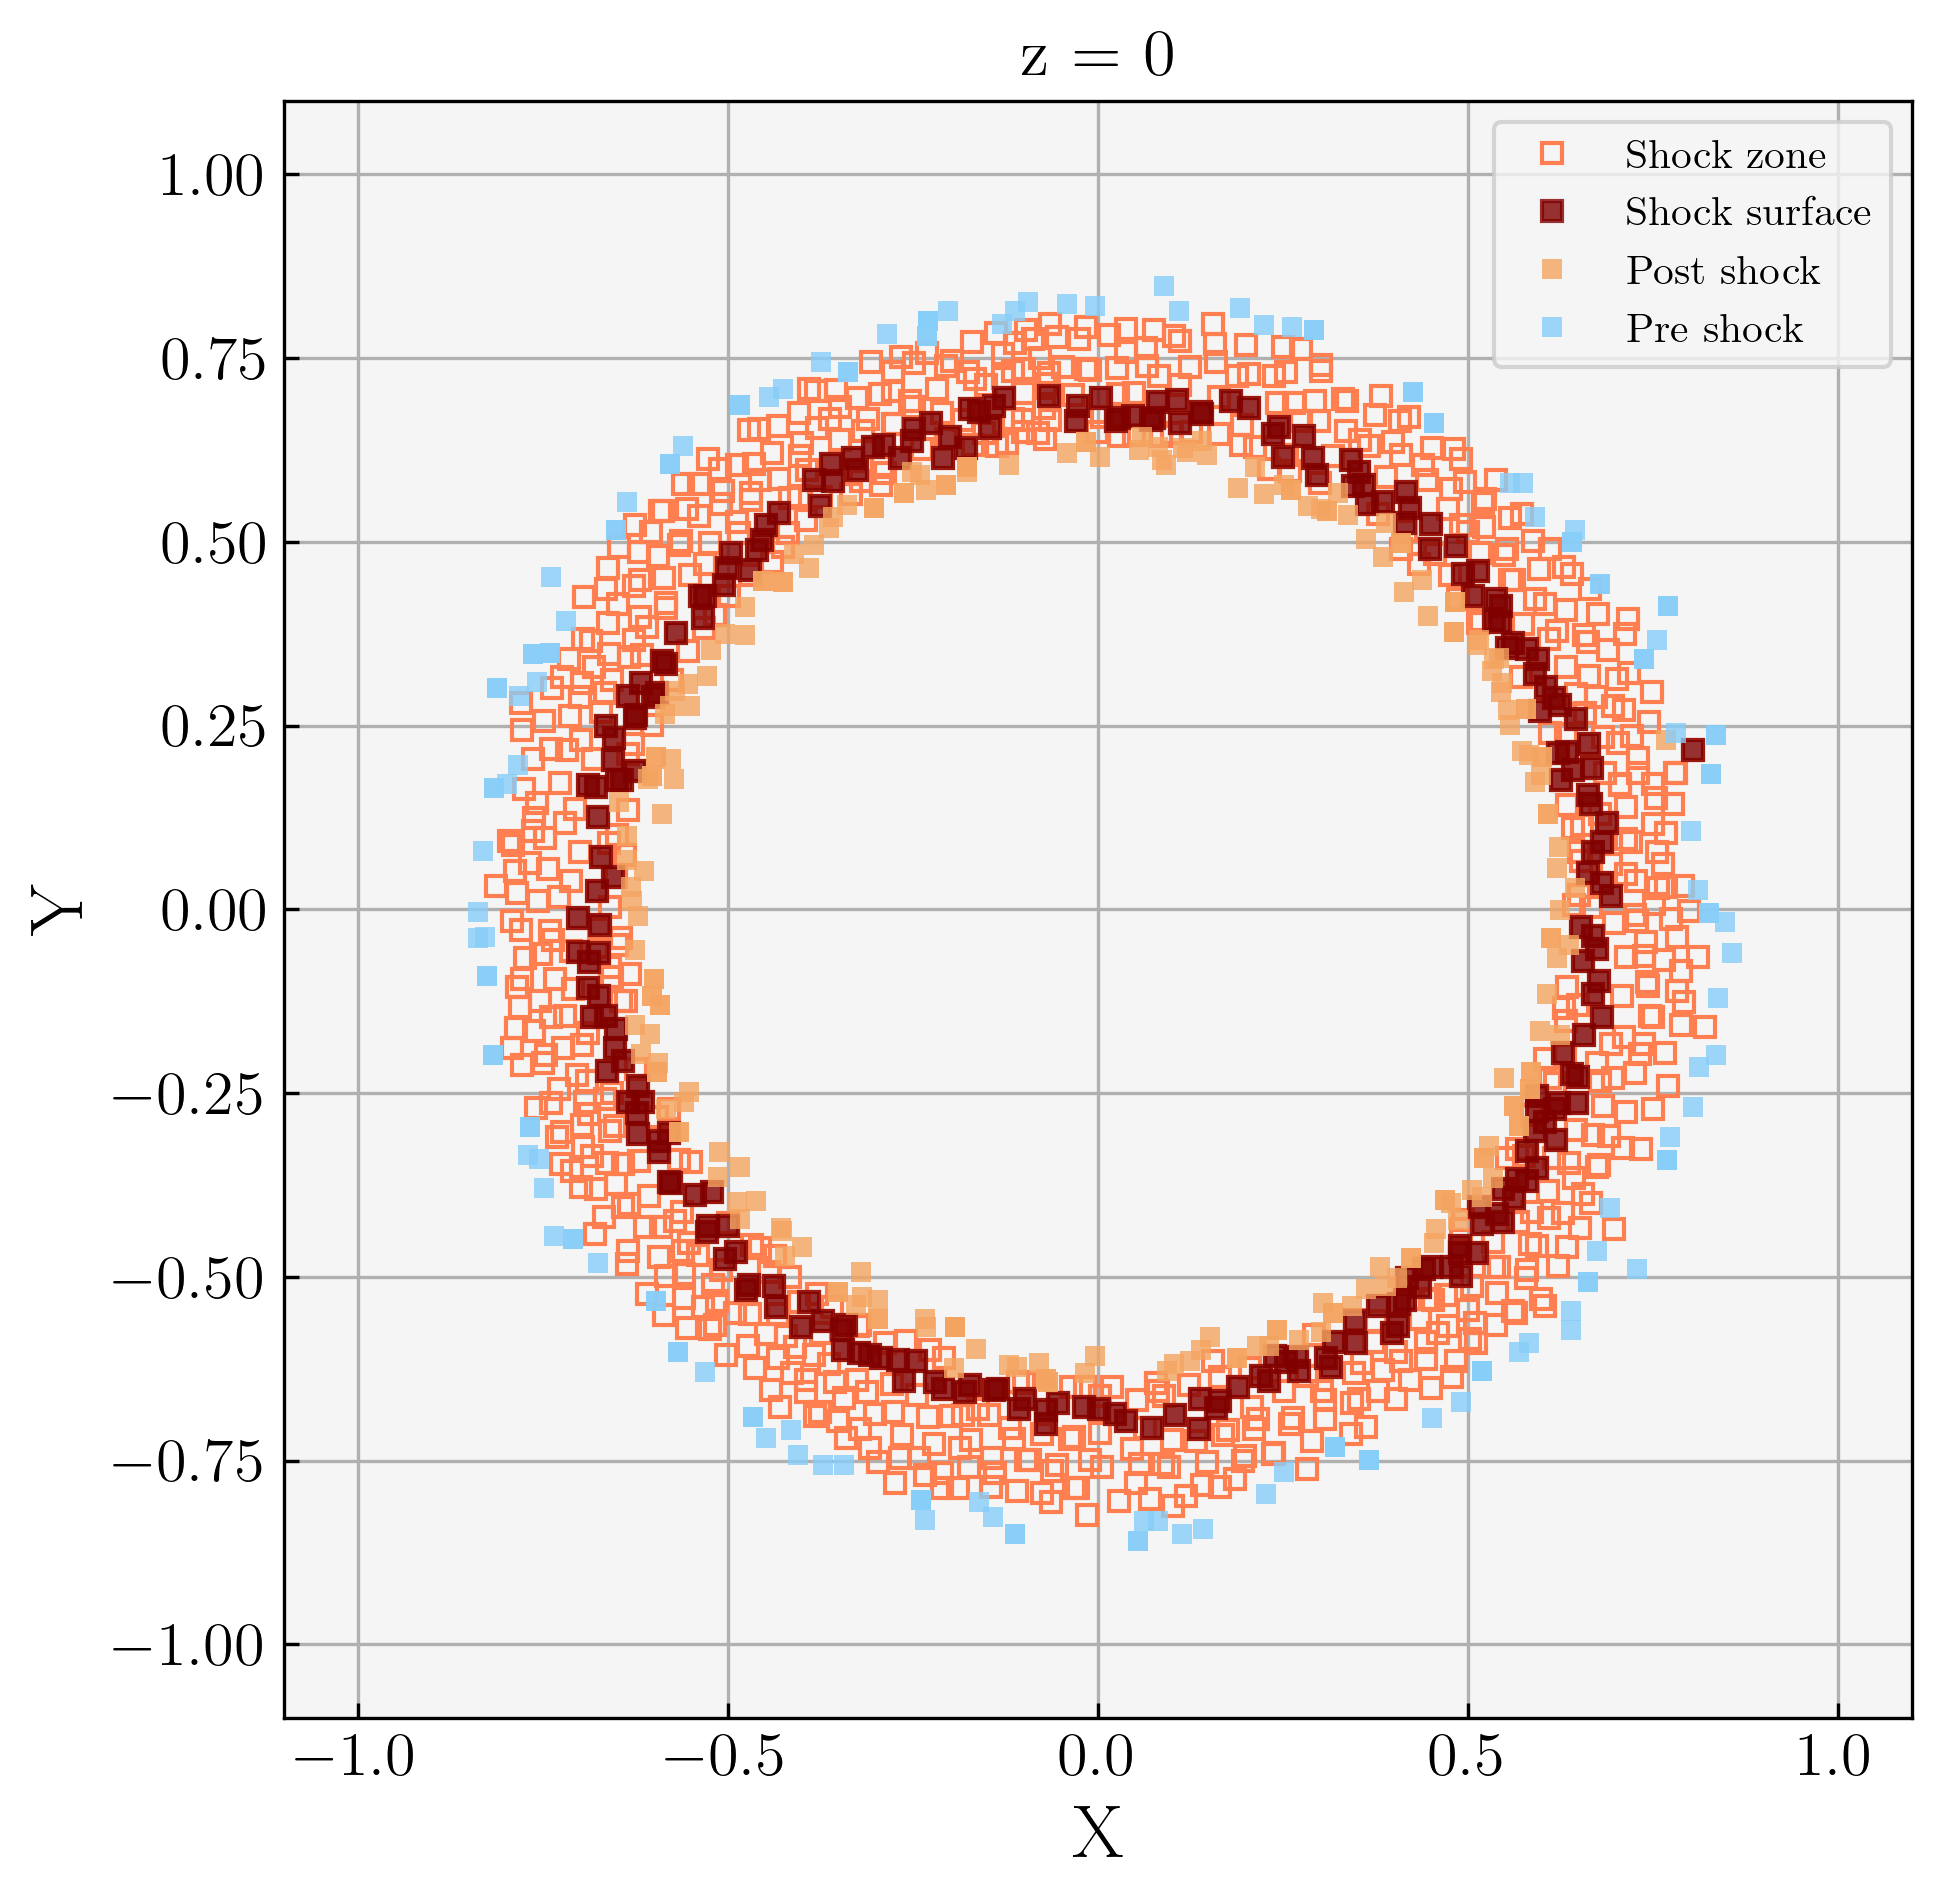

In [72]:
# Maybe for every cell of the shock surface you don't see pre/post because they are not on the same layers
fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='coral', label = 'Shock zone')
ax.plot(surface_cross_x, surface_cross_y, 'ks', markerfacecolor='maroon', ms = 5, markeredgecolor='maroon',  alpha = 0.8, label = 'Shock surface')


ax.plot(zone_post_x, zone_post_y, 'ks', markerfacecolor='sandybrown', ms = 5, markeredgecolor='none', alpha = 0.8,  label = 'Post shock')
ax.plot(zone_pre_x, zone_pre_y, 'ks', markerfacecolor='lightskyblue', ms = 5, markeredgecolor='none', alpha = 0.8,  label = 'Pre shock')

# ax.plot(surface_cross_x[outlier], surface_cross_y[outlier], 'ks', markerfacecolor='r', ms = 7, markeredgecolor='r',  label = 'outlier')
# ax.plot(post_x[slice_surface][outlier], post_y[slice_surface][outlier], 'ks', markerfacecolor='orange', ms = 7, markeredgecolor='orange',  label = 'outlier post')
# ax.plot(pre_x[slice_surface][outlier], pre_y[slice_surface][outlier], 'ks', markerfacecolor='b', ms = 7, markeredgecolor='b',  label = 'outlier pre')

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.set_xlabel('X', fontsize = 18)
ax.set_ylabel('Y', fontsize = 18)
ax.legend()
ax.set_title(f'z = {z_chosen}', fontsize = 16)
plt.grid()
plt.savefig(f'Figs/5shocksurface_z{z_chosen}.png')

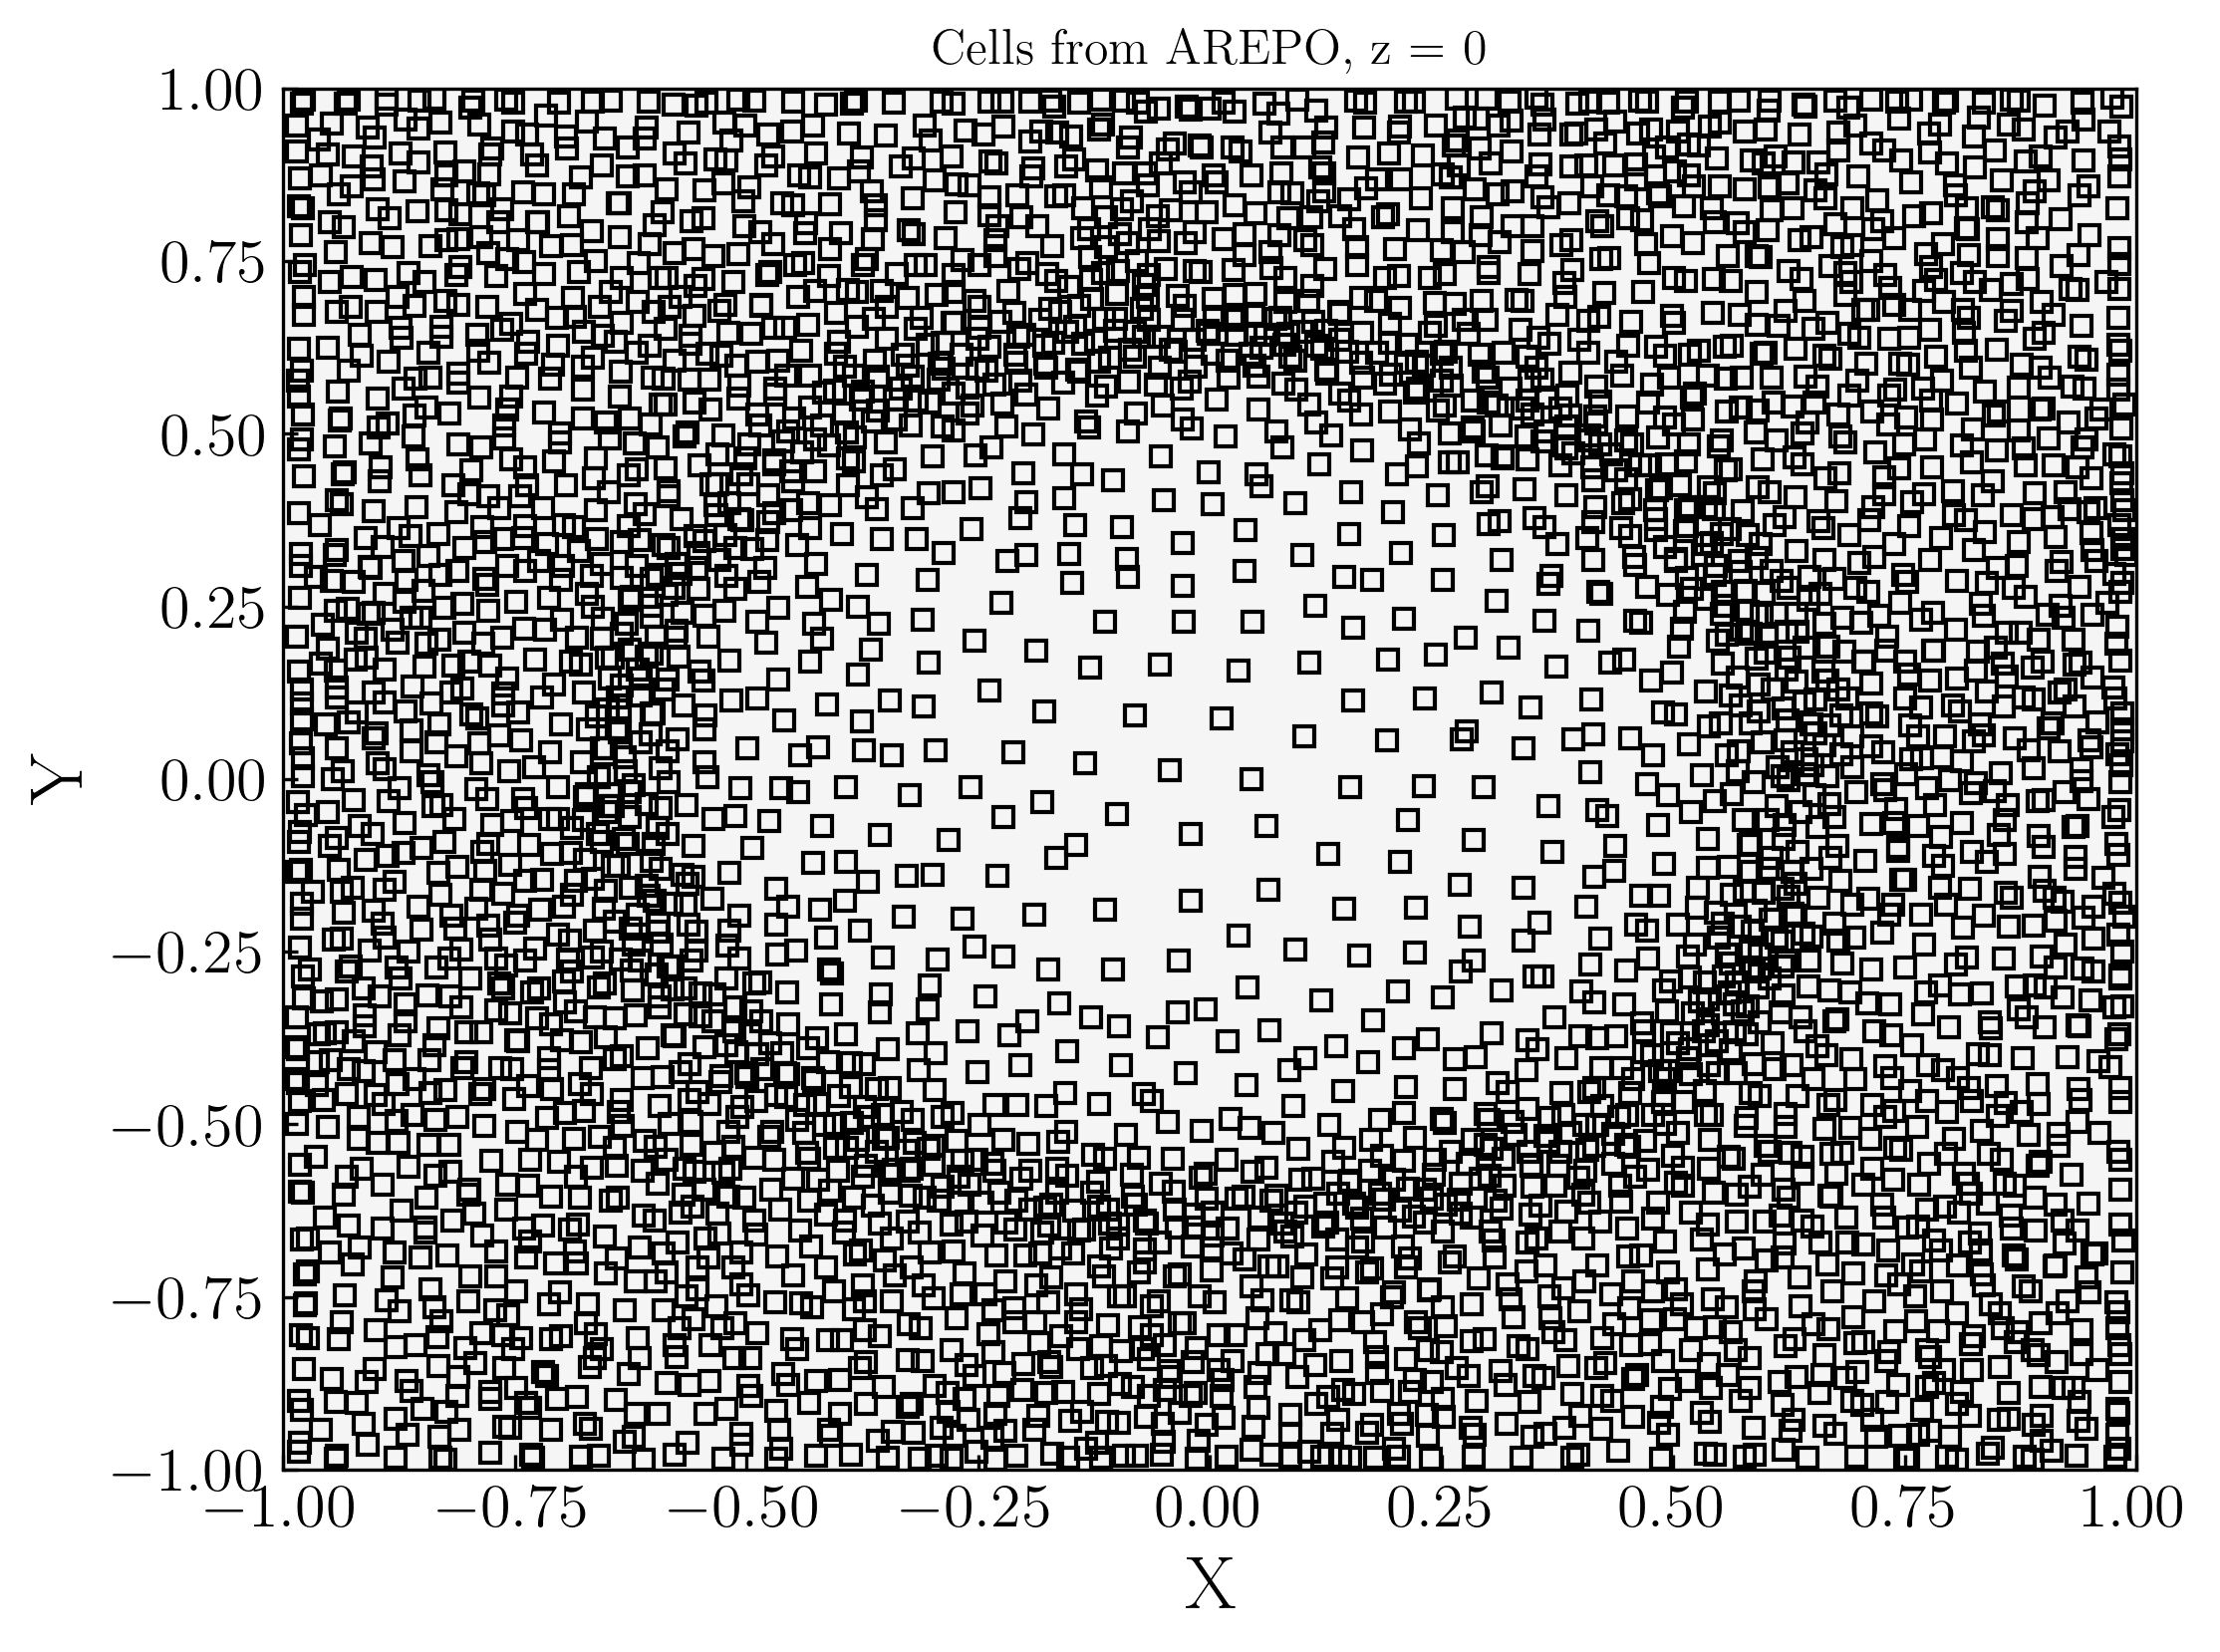

In [69]:
fig, ax = plt.subplots(1,1)
ax.plot(X[np.logical_and(Z<z_chosen+delta, Z>z_chosen-delta)], Y[np.logical_and(Z<z_chosen+delta, Z>z_chosen-delta)], 'ks', markerfacecolor='none', ms = 5, markeredgecolor='k')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xlabel('X', fontsize = 18)
ax.set_ylabel('Y', fontsize = 18)
plt.title(f'Cells from AREPO, z = {z_chosen}')
# plt.savefig('Figs/0cross_section.png')
plt.show()